---
title: "强化学习专题 - N-Step 强化学习的改进"
date: 2025-06-09T17:51:00+08:00
author: "Liu Zheng"
tags: ["笔记", "实验", "AI", "强化学习"]
categories: "实验笔记"
---

# N-Step 强化学习的改进

`Q-Learning` 和 `SARSA` 这两种时间差分（TD）强化学习方法在基本形式上存在以下四个主要弱点：

1.  **奖励传播缓慢与稀疏奖励问题**：与蒙特卡洛方法不同，TD 方法使用自举（bootstrapping）来估计未来的折扣奖励。这意味着对于奖励稀疏的问题，奖励信号可能需要很长时间才能在Q-函数中传播开来。由于算法初期行为完全随机，这使得它们难以发现并利用稀疏的非零奖励。
2.  **奖励稀疏性**：环境中只有少数状态/动作能带来非零奖励，导致初始阶段的随机探索难以发现有价值的奖励，从而阻碍学习进程。
3.  **Q 表规模限制**：这两种方法都通过 Q 表来存储 Q 函数。然而，对于任何非平凡的问题，Q 表的大小（$|A| \times |S|$，其中 $|A|$ 是动作空间大小， $|S|$ 是状态空间大小）会变得极其庞大，导致存储和维护上的困难。
4.  **未访问状态的 Q 值估计缺失**：使用 Q 表要求多次访问每个可达状态并多次执行每个动作，才能获得 Q 函数的良好估计。因为 Q 表是离散空间，因此之前的策略更新不同步和疏漏都会降低训练质量。

接下来我们开始进行 N-Step 强化学习训练，由于 `FrozenLake` 的特殊性（只有终点存在奖励）导致存在 N 步缓冲的意义不大，将场景改为 `CliffWalking`。

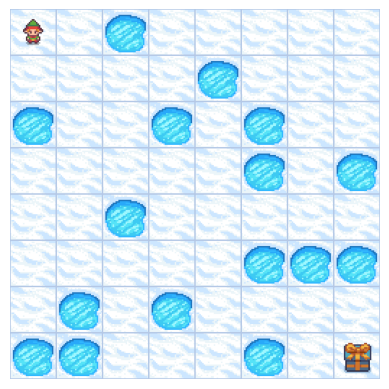

In [1]:
import gymnasium
import matplotlib.pyplot
import numpy
from collections import defaultdict, deque
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

SIZE = 8
FONT = "Sarasa Fixed SC"

ENV = gymnasium.make("FrozenLake-v1", desc=generate_random_map(SIZE), map_name=f"{SIZE}x{SIZE}", is_slippery=False, render_mode="rgb_array")
ENV.reset()

image = ENV.render()

matplotlib.pyplot.imshow(image)
matplotlib.pyplot.axis("off")
matplotlib.pyplot.show()

## 1. 基础概念

我们之前进行了基于采样的蒙特卡洛方法和基于 Q 表的时序差分方法，蒙特卡洛方法实现了采样的记录，Q 表的方法实现了价值列表，现在将两者相结合，增加一种滑动窗口的价值更新机制，即 N-Step 时序差分（N-Step TD）方法。N-Step TD 通过在每一步更新时，结合未来 N 步的奖励和状态信息，使得奖励信号能够更快地在 Q 表中传播，从而在稀疏奖励环境下提升学习效率。

![image](https://gibberblot.github.io/rl-notes/_images/RL_approaches.png)

> **N-Step SARSA 算法实现**
> 
> $
> \begin{array}{l}
> \text{input}:\ \text{MDP}\ = \{ S, s_0, A, P(s' \mid s, a), R(s,a,s') \}\, \text{number of steps n}\\
> \text{output}:\ \text{Q-function}\ Q\\[2mm]
> \text{Initialise}\ Q\ \text{arbitrarily; e.g., }\ Q(s,a)=0\ \text{for all}\ s\ \text{and}\ a\\[2mm]
> \text{repeat} \\
> \quad\quad \text{Select action}\ a\ \text{to apply in}\ s\ \text{using Q-values in}\ Q\ \text{and}\\
> \quad\quad\quad\quad \text{a multi-armed bandit algorithm such as}\ \epsilon\text{-greedy}\\
> \quad\quad \vec{s} = \{ s \}, \vec{a} = \{ a \}, \vec{r} = \{ \}\\
> \quad\quad \text{while}\ \vec{s}\ \text{is not empty}\ \text{do}\\
> \quad\quad\quad\quad\ \text{if}\ s\ \text{is not a terminal state}\ \text{then}\\
> \quad\quad\quad\quad\quad\quad \text{Execute action}\ a\ \text{in state}\ s\\
> \quad\quad\quad\quad\quad\quad \text{Observe reward}\ r\ \text{and new state}\ s'\\
> \quad\quad\quad\quad\quad\quad \vec{r} \leftarrow \vec{r} + \{ r \}\\
> \quad\quad\quad\quad\quad\quad \text{if}\ s'\ \text{is not a terminal state}\ \text{then}\\
> \quad\quad\quad\quad\quad\quad\quad\quad \text{Select action}\ a'\ \text{to apply in}\ s'\ \text{using}\ Q\ \text{and a multi-armed bandit algorithm}\\
> \quad\quad\quad\quad\quad\quad\quad\quad \vec{s} \leftarrow \vec{s} + \{ s' \}, \vec{a} \leftarrow \vec{s} + \{ a' \}\\
> \quad\quad\quad\quad \text{if}\ |\vec{r}| = n\ \text{or}\ s\ \text{is a terminal state}\ \text{if}\\
> \quad\quad\quad\quad\quad\quad G \leftarrow \sum^{|\vec{r}| - 1}_{i=0}\gamma^{i}\vec{r}_i\\
> \quad\quad\quad\quad\quad\quad \text{if}\ s\ \text{is not a terminal state}\ \text{then}\\
>  \quad\quad\quad\quad\quad\quad\quad\quad G \leftarrow G + \gamma^n Q(s', a'), Q(\vec{s}_0, \vec{a}_0) \leftarrow  Q(\vec{s}_0, \vec{a}_0) + \alpha[G - Q(\vec{s}_0, \vec{a}_0)]\\
> \quad\quad\quad\quad\quad\quad \vec{r} \leftarrow \vec{r}_{[1 : n + 1]}, \vec{s} \leftarrow \vec{s}_{[1 : n + 1]}, \vec{a} \leftarrow \vec{a}_{[1 : n + 1]}\\
> \quad\quad\quad\quad s \leftarrow s', a \leftarrow a'\\
> \text{until}\ Q\ \text{converges}
> \end{array}
> $

In [2]:
class NSAMDP:
    def __init__(self, env):
        self.env = env
        self.S = range(env.observation_space.n)
        self.A = range(env.action_space.n)
        self.Qt = defaultdict(lambda: numpy.zeros(env.action_space.n))

    def choose(self, s, eps):
        if numpy.random.rand() < eps:
            return self.env.action_space.sample()
        return numpy.argmax(self.Qt[s])

    def next(self, s, a):
        sn, Rsa, done, truncated, _ = self.env.step(a)
        if done and Rsa == 1.0:
            return sn, Rsa, done, truncated
        if done and Rsa == 0.0:
            return sn, -1.0, done, truncated
        if truncated:
            return sn, -0.1, done, truncated
        sx, sy = s // SIZE, s % SIZE
        snx, sny = sn // SIZE, sn % SIZE
        phis = 1.0 - (abs(sx - SIZE + 1) + abs(sy - SIZE + 1)) / (2 * SIZE - 2)
        phisn = 1.0 - (abs(snx - SIZE + 1) + abs(sny - SIZE + 1)) / (2 * SIZE - 2)
        return sn, Rsa + 0.99 * phisn - phis, done, truncated

    def build(self, alpha=0.1, gamma=0.99, epis=1000, eps=1.0, steps=3):
        for n in range(epis):
            ceps = max(0.01, eps * (0.995**n))
            s, _ = self.env.reset()
            a = self.choose(s, ceps)
            sq, aq, rq = deque(), deque(), deque()
            done, truncated = False, False
            t = 0
            while not done and not truncated:
                sn, r, done, truncated = self.next(s, a)
                sq.append(s)
                aq.append(a)
                rq.append(r)
                if not done and not truncated:
                    an = self.choose(sn, ceps)
                else:
                    an = None
                if len(sq) == steps or done or truncated:
                    G = 0
                    for i in range(len(rq)):
                        G += (gamma**i) * rq[i]
                    if not done and not truncated:
                        G += (gamma**steps) * self.Qt[sn][an]
                    su = sq.popleft()
                    au = aq.popleft()
                    rq.popleft()
                    self.Qt[su][au] += alpha * (G - self.Qt[su][au])
                s, a = sn, an
                t += 1
                if done or truncated:
                    break
            while len(sq) > 0:
                G = 0.0
                for i in range(len(rq)):
                    G += (gamma**i) * rq[i]
                su = sq.popleft()
                au = aq.popleft()
                rq.popleft()
                self.Qt[su][au] += alpha * (G - self.Qt[su][au])

    def decision(self, s):
        return int(numpy.argmax(self.Qt[s])), numpy.argmax(self.Qt[s])

    def evaluate(self, figure):
        image = self.env.render()
        subplot = figure.add_subplot()
        subplot.axis("off")
        subplot.imshow(image)
        ih, iw, _ = image.shape
        ch, cw = ih // SIZE, iw // SIZE  # Cell height and width
        s, _ = self.env.reset()
        for i in range(SIZE):
            for j in range(SIZE):
                Qs0 = self.Qt[i * SIZE + j][0]
                Qs1 = self.Qt[i * SIZE + j][1]
                Qs2 = self.Qt[i * SIZE + j][2]
                Qs3 = self.Qt[i * SIZE + j][3]
                subplot.text(j * cw + cw - 42, i * ch + 12, f"L:{Qs0: >5.2f}", fontsize=6, fontfamily=FONT)
                subplot.text(j * cw + cw - 42, i * ch + 24, f"D:{Qs1: >5.2f}", fontsize=6, fontfamily=FONT)
                subplot.text(j * cw + cw - 42, i * ch + 36, f"R:{Qs2: >5.2f}", fontsize=6, fontfamily=FONT)
                subplot.text(j * cw + cw - 42, i * ch + 48, f"U:{Qs3: >5.2f}", fontsize=6, fontfamily=FONT)
        while True:
            a, _ = self.decision(s)
            s, _, done, truncated = self.next(s, a)
            if done or truncated:
                break
            subplot.plot(s % SIZE * cw + cw // 2, s // SIZE * ch + ch // 2, marker="o", markersize=8, color="red", alpha=0.5)

    def simulation(self, epis=100):
        count = 0
        for episode in range(epis):
            s, _ = self.env.reset()
            done, truncated = False, False
            while not done and not truncated:
                a, _ = self.decision(s)
                s, _, done, truncated = self.next(s, a)
                if done:  # In FrozenLake, reward is 1.0 only upon reaching 'G'
                    count += 1
        success_rate = count / epis * 100
        print(f"\nRunning {epis} episodes using the optimal policy:")
        print(f"Success Rate: {success_rate:.2f}%")


Running 100 episodes using the optimal policy:
Success Rate: 100.00%


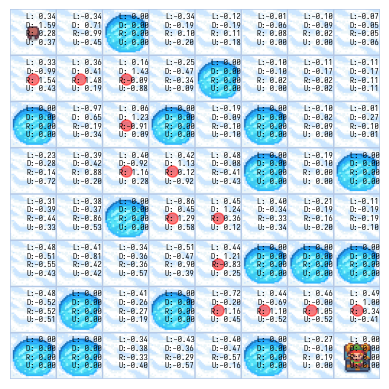

In [3]:
INSTANCE = NSAMDP(ENV)

INSTANCE.build()
INSTANCE.evaluate(matplotlib.pyplot.figure())
INSTANCE.simulation()

ENV.close()